In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import hosts
import targeting

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar

from collections import Counter

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

In [5]:
from IPython import display

In [6]:
def make_cutout_comparison_table(dcat):
    """
    Produces a table comparing DECaLS and SDSS objects side-by-side
    
    `dcat` should be a *DECaLS* catalog, not SDSS
    """
    de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=decals-dr3&pixscale=0.1&bands=grz'
    sd_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=sdssco&pixscale=0.1&bands=gri'

    print('put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx')
    print('name ra dec')

    tabrows = []
    for row in dcat:
        dviewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row['ra'], row['dec'])
        sviewurl = 'http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra={}&dec={}'.format(row['ra'], row['dec'])
        sc = SkyCoord(row['ra'], row['dec'], unit=u.deg)
        objstr = '{}_{}<br>RA={:.4f}<br>Dec={:.4f}<br>r={:.2f}<br>sb={:.2f}'.format(row['brickid'], row['objid'], row['ra'], row['dec'], row['r'], row['sb_r_0.5'])
        deimg = '<a href="{}"><img src="{}"></a>'.format(dviewurl, de_cutout_url.format(sc))
        sdimg = '<a href="{}"><img src="{}"></a>'.format(sviewurl, sd_cutout_url.format(sc))
        tabrows.append('<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(objstr, deimg, sdimg))
        print(row['brickname']+'_'+str(row['objid']), row['ra'], row['dec'])

    htmlstr = """
    <table>

    <tr>
    <th>obj</th>
    <th>DECALS</th>
    <th>SDSS</th>
    </tr>

    {}
    </table>
    """.format('\n'.join(tabrows))
    
    return display.HTML(htmlstr)

# Get AnaK/brick info

In [7]:
hsts = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
anak  = [h for h in hsts if h.name=='AnaK']
assert len(anak)==1
anak = anak[0]

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [8]:
bricknames = []
with open('decals_dr3/anakbricks') as f:
    for l in f:
        l = l.strip()
        if l != '':
            bricknames.append(l)
print(bricknames)

['3538m007', '3541m007', '3543m007', '3546m007', '3533m005', '3536m005', '3538m005', '3541m005', '3543m005', '3546m005', '3548m005', '3531m002', '3533m002', '3536m002', '3538m002', '3541m002', '3543m002', '3546m002', '3548m002', '3551m002', '3531p000', '3533p000', '3536p000', '3538p000', '3541p000', '3543p000', '3546p000', '3548p000', '3551p000', '3531p002', '3533p002', '3536p002', '3538p002', '3541p002', '3543p002', '3546p002', '3548p002', '3551p002', '3531p005', '3533p005', '3536p005', '3538p005', '3541p005', '3543p005', '3546p005', '3548p005', '3551p005', '3531p007', '3533p007', '3536p007', '3538p007', '3541p007', '3543p007', '3546p007', '3548p007', '3551p007', '3533p010', '3536p010', '3538p010', '3541p010', '3543p010', '3546p010', '3548p010', '3536p012', '3538p012', '3541p012', '3543p012', '3546p012']


# Download the catalogs if needed 

In [9]:
base_url = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/tractor/{first3}/tractor-{brickname}.fits'

for brickname in ProgressBar(bricknames, ipython_widget=True):
    url = base_url.format(brickname=brickname, first3=brickname[:3])
    target = os.path.join('decals_dr3/catalogs/', url.split('/')[-1])
    if not os.path.isfile(target):
        !wget $url -O $target
    else:
        print(target, 'already exists, not downloading')

decals_dr3/catalogs/tractor-3538m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3541m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3543m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3546m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3533m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3536m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3538m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3541m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3543m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3546m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3548m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3531m002.fits already exists, not downloading
decals_dr3/catalogs/tractor-3533m002.fits already exists, not downloading
decals_dr3/catalogs/tractor-3536m002.f

# Load the catalogs 

In [10]:
bricks = Table.read('decals_dr3/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')

In [11]:
catalog_fns = ['decals_dr3/catalogs/tractor-{}.fits'.format(bnm) for bnm in bricknames]
decals_catalogs = [Table.read(fn) for fn in catalog_fns]
dcatall = table.vstack(decals_catalogs, metadata_conflicts='silent')

In [12]:
sdss_catalog = Table.read('catalogs/base_sql_nsa{}.fits.gz'.format(anak.nsaid))

#  Quickly Examine the catalogs

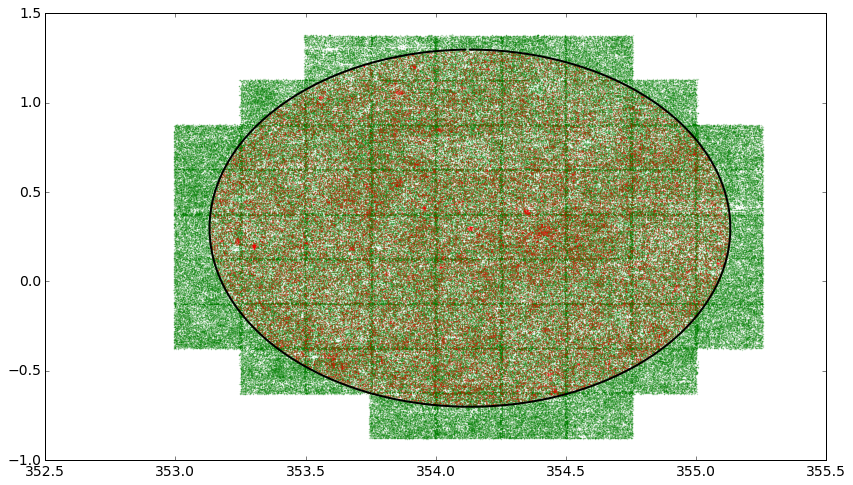

In [13]:
plt.scatter(dcatall['ra'], dcatall['dec'], lw=0, c='g', s=2, alpha=.25)
plt.scatter(sdss_catalog['ra'], sdss_catalog['dec'], lw=0, c='r', s=2, alpha=.25)

csize = 1*u.deg
phase = np.arange(360)*u.deg
xc = anak.coords.ra + csize * np.sin(phase)
yc = anak.coords.dec + csize * np.cos(phase)
plt.plot(xc, yc, lw=2, c='k')

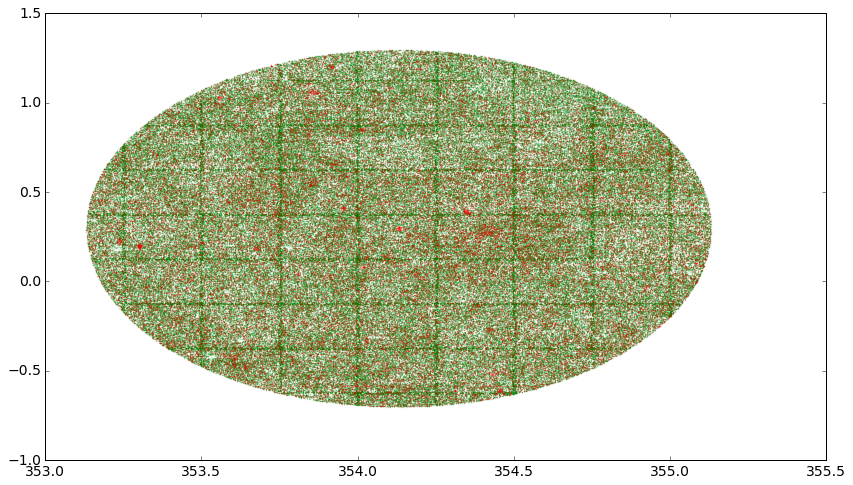

In [14]:
#cut out the non-overlap region
dsc = SkyCoord(dcatall['ra'], dcatall['dec'], unit=u.deg)
dcutall = dcatall[dsc.separation(anak.coords) < 1*u.deg]

plt.scatter(dcutall['ra'], dcutall['dec'], lw=0, c='g', s=2, alpha=.25)
plt.scatter(sdss_catalog['ra'], sdss_catalog['dec'], lw=0, c='r', s=2, alpha=.25)

Not the over-density in the brick boundaries.  I think that's because the bricks have a bit of overlap.  Could cut that to get the statistics right if necessary, but for now will leave it in for simplicity.

# Galaxy detection depth 

In [15]:
maggaldepth = -2.5*(np.log10(5*dcutall['decam_galdepth']**-0.5)-9)
maggaldepthr = maggaldepth[:, 2]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


(22, 25.5)

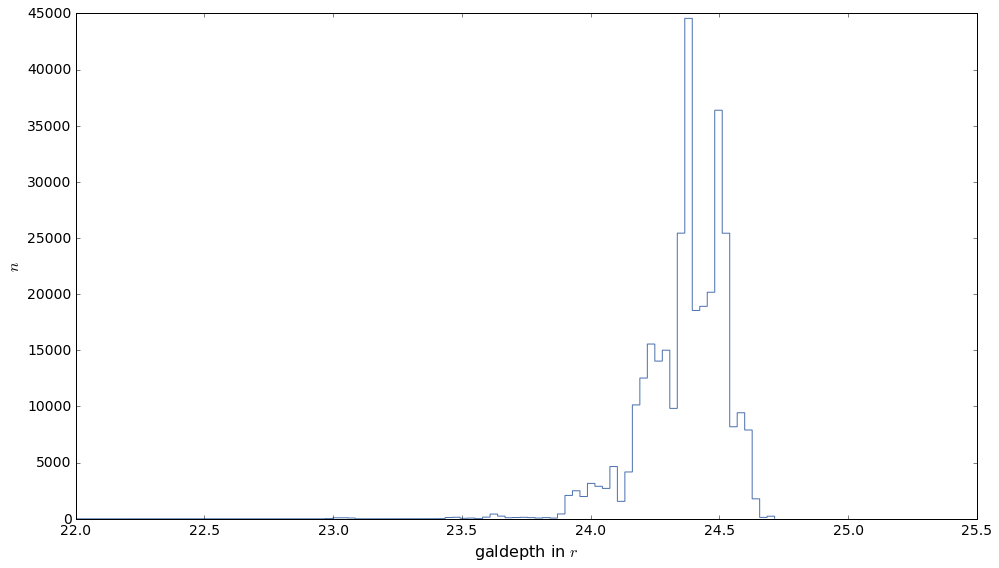

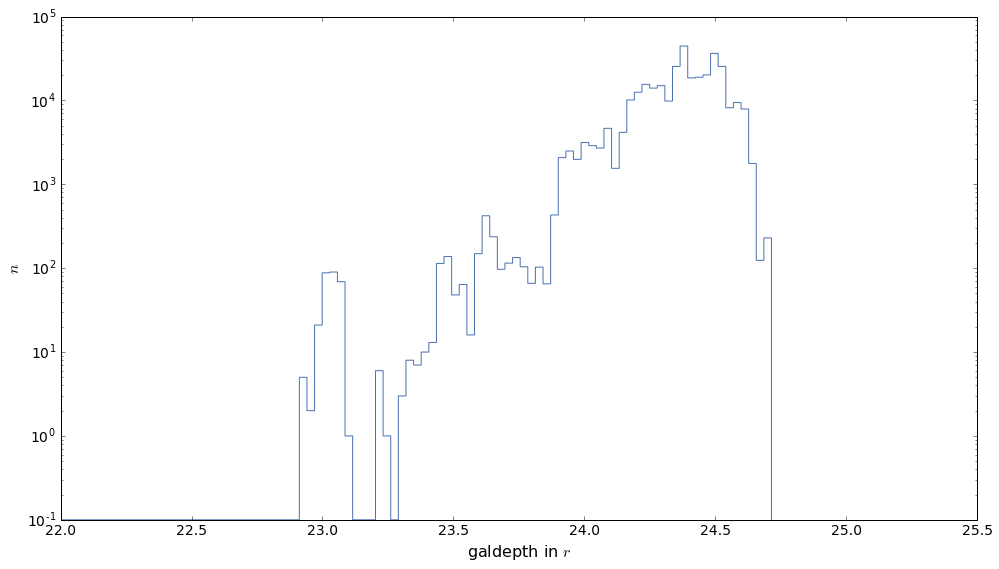

In [16]:
plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=False)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()
plt.xlim(22, 25.5)

plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=True)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()
plt.xlim(22, 25.5)

## Populate additional  info in the DECaLS tables

In [17]:
ap_sizes = [0.5,0.75,1.0,1.5,2.0,3.5,5.0,7.0] * u.arcsec 

In [50]:
def compute_sb(rad, apflux):
    if len(apflux.shape)==2:
        idxs = np.where(ap_sizes==rad)[0]
        assert len(idxs)==1, 'No aperture with size {}'.format(rad)
        
        apflux = apflux[:, idxs[0]]
    A = 2.5*np.log10(np.pi*(rad.to(u.arcsec).value)**2)
    return np.array(22.5 - 2.5*np.log10(apflux) + A) * u.mag * u.arcsec**-2
        
for dcat in [dcutall]:
    dcat['g'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 1]))*u.mag
    dcat['r'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 2]))*u.mag
    dcat['z'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 4]))*u.mag
    
    dcat['sb_r_0.5'] = compute_sb(0.5*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_0.75'] = compute_sb(0.75*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_1'] = compute_sb(1.0*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_2'] = compute_sb(2.0*u.arcsec, dcat['decam_apflux'][:, 2, :])

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/sag

# Compute SDSS-like SB's

Details outlined in "DECALS low-SB_completeness figures" notebook

In [19]:
dcat = dcutall
rap_fluxes = dcat['decam_apflux'][:, 2, :]

expflux_r = np.empty_like(rap_fluxes[:, 0])
rad = np.empty(len(rap_fluxes[:, 0]))
ap_sizesv = ap_sizes.to(u.arcsec).value

intr = interpolate.BarycentricInterpolator(ap_sizesv, [0]*len(ap_sizesv))
for i in ProgressBar(range(len(rap_fluxes)), ipython_widget=True):
    f = rap_fluxes[i]
    if dcat['type'][i] == 'PSF ':
        r = dcat['decam_psfsize'][i, 2]
    elif dcat['type'][i] == 'DEV ':
        r = dcat['shapeDev_r'][i]
    else:
        r = dcat['shapeExp_r'][i]

    intr.set_yi(f)
    expflux_r[i] = intr(r)
    rad[i] = r

dcat['sdss_like_sb_r'] = compute_sb(rad*u.arcsec, np.array(expflux_r))

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


# X-matching catalogs

In [53]:
dsc = SkyCoord(dcutall['ra'], dcutall['dec'], unit=u.deg)
ssc = SkyCoord(sdss_catalog['ra'], sdss_catalog['dec'], unit=u.deg)

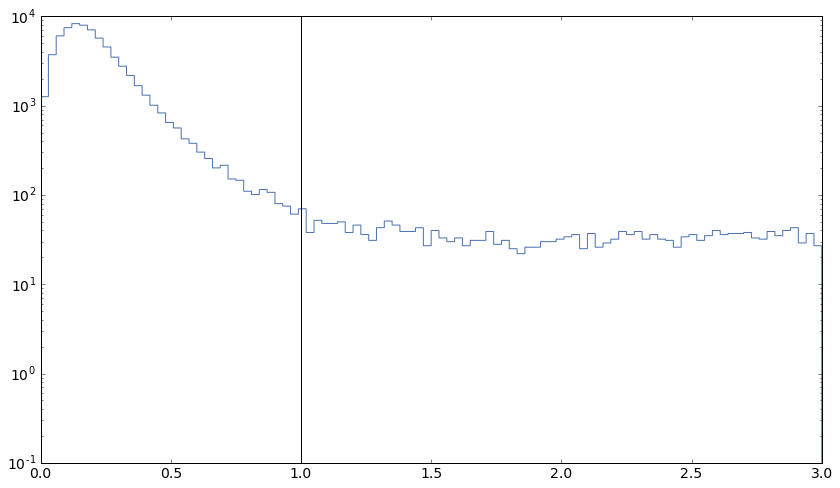

In [54]:
idx, d2d, _ = ssc.match_to_catalog_sky(dsc)
plt.hist(d2d.arcsec, bins=100, range=(0, 3),histtype='step', log=True)
plt.axvline(1.0, c='k')
None

In [70]:
dmatchmsk = idx[d2d<1.0*u.arcsec]
dmatch = dcutall[dmatchmsk]

smatch = sdss_catalog[d2d<1.0*u.arcsec]

In [71]:
didxs = np.arange(len(dcutall))
dnomatchmsk = didxs[~np.in1d(didxs, idx[d2d<1.0*u.arcsec])]
dnomatch = dcutall[dnomatchmsk]

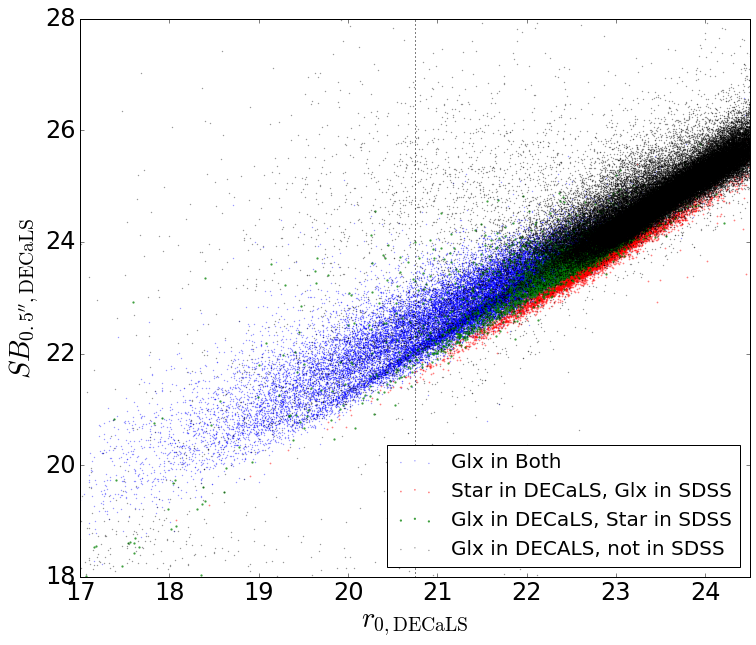

In [88]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['phot_sg']==6

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.4, s=2, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, s=3, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.75, s=5, label='Glx in DECaLS, Star in SDSS')

dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.4, s=2, label='Glx in DECALS, not in SDSS')

#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.5^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)
#plt.savefig(os.environ['HOME'] + '/Desktop/fig_decals.pdf')

### Galaxies in DECaLS w/ low SB

In [98]:
to_check = dcutall[(dcutall['r']<21)&(dcutall['sb_r_0.5']>24.5) & (dcutall['type']!='PSF ')]

np.random.shuffle(to_check)
print('n=', len(to_check))
make_cutout_comparison_table(to_check[:25])

n= 413
put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
3538m007_5579 353.952019336 -0.66210732761
3541m007_5058 354.180079568 -0.684272851969
3541m007_5058 354.180079568 -0.684272851969
3533m005_5486 353.451141773 -0.41087886344
3538m007_5579 353.952019336 -0.66210732761
3536m005_5262 353.527387286 -0.435739783021
3538m007_5579 353.952019336 -0.66210732761
3533m005_5486 353.451141773 -0.41087886344
3536m005_5473 353.683329933 -0.422611582373
3536m005_5262 353.527387286 -0.435739783021
3538m005_203 353.853915319 -0.620524388494
3538m005_203 353.853915319 -0.620524388494
3541m007_5058 354.180079568 -0.684272851969
3543m007_6426 354.468390296 -0.637404930283
3541m005_2263 354.121132885 -0.543444547042
3541m005_2263 354.121132885 -0.543444547042
3538m005_238 353.851301874 -0.618998643595
3538m005_238 353.851301874 -0.618998643595
3541m005_6078 354.213248692 -0.402753271643
3536m005_5473 353.683329933 -0.422611582373
3541m005_6451 354.104580586 -0.38702

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


obj,DECALS,SDSS
327463_5579RA=353.9520Dec=-0.6621r=20.48sb=29.55,,
327464_5058RA=354.1801Dec=-0.6843r=20.98sb=24.85,,
327464_5058RA=354.1801Dec=-0.6843r=20.98sb=24.85,,
328901_5486RA=353.4511Dec=-0.4109r=20.34sb=25.31,,
327463_5579RA=353.9520Dec=-0.6621r=20.48sb=29.55,,
328902_5262RA=353.5274Dec=-0.4357r=20.94sb=25.02,,
327463_5579RA=353.9520Dec=-0.6621r=20.48sb=29.55,,
328901_5486RA=353.4511Dec=-0.4109r=20.34sb=25.31,,
328902_5473RA=353.6833Dec=-0.4226r=20.47sb=25.55,,
328902_5262RA=353.5274Dec=-0.4357r=20.94sb=25.02,,


### Galaxies in DECaLS, *nothing* in SDSS

In [110]:
to_check = dnomatch[((18<dnomatch['r']) & (dnomatch['r']<21) &
            (18<dnomatch['sb_r_0.5']) & (dnomatch['sb_r_0.5']<24.5) & 
            (dnomatch['type']!='PSF '))]

np.random.shuffle(to_check)
print('n=', len(to_check))
make_cutout_comparison_table(to_check[:25])

n= 1479
put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
3538m007_6112 353.994833189 -0.644026467428
3538m007_6112 353.994833189 -0.644026467428
3538m007_6193 353.857177325 -0.624029738056
3538m007_6182 353.859391581 -0.637236857753
3538m007_6493 353.760815569 -0.625649432021
3538m007_6182 353.859391581 -0.637236857753
3541m007_5604 354.00184977 -0.66441892507
3541m007_5604 354.00184977 -0.66441892507
3538m007_6193 353.857177325 -0.624029738056
3538m007_6510 353.992276406 -0.623513463188
3538m007_6510 353.992276406 -0.623513463188
3541m007_6767 354.079816274 -0.624075996171
3538m007_6193 353.857177325 -0.624029738056
3538m007_6182 353.859391581 -0.637236857753
3538m007_6510 353.992276406 -0.623513463188
3541m007_6811 354.085222008 -0.62262264809
3538m007_6112 353.994833189 -0.644026467428
3541m007_6811 354.085222008 -0.62262264809
3541m007_6811 354.085222008 -0.62262264809
3541m007_6877 354.18465214 -0.620902396374
3541m007_5423 354.000209847 -0.669

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


obj,DECALS,SDSS
327463_6112RA=353.9948Dec=-0.6440r=20.55sb=21.52,,
327463_6112RA=353.9948Dec=-0.6440r=20.55sb=21.52,,
327463_6193RA=353.8572Dec=-0.6240r=20.92sb=22.44,,
327463_6182RA=353.8594Dec=-0.6372r=20.63sb=21.90,,
327463_6493RA=353.7608Dec=-0.6256r=20.49sb=21.99,,
327463_6182RA=353.8594Dec=-0.6372r=20.63sb=21.90,,
327464_5604RA=354.0018Dec=-0.6644r=20.46sb=21.65,,
327464_5604RA=354.0018Dec=-0.6644r=20.46sb=21.65,,
327463_6193RA=353.8572Dec=-0.6240r=20.92sb=22.44,,
327463_6510RA=353.9923Dec=-0.6235r=21.00sb=22.46,,


In [119]:
sci = SkyCoord(to_check[0]['ra'], to_check[0]['dec'], unit=u.deg)
sci.match_to_catalog_sky(ssc)[1].arcsec

array([ 0.22525877])

One of the non-matches has a match?? suspicious...

### Gals in DECaLS, stars in SDSS 

In [109]:
to_check = dmatch[~dstar&sstar&(dmatch['r']<21)]

np.random.shuffle(to_check)
print(len(to_check))
make_cutout_comparison_table(to_check[:25])

189
put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
3541p002_325 354.030258984 0.135485044552
3543p002_2208 354.257459883 0.201174686276
3543p005_140 354.352428456 0.39355706821
3543p002_2208 354.257459883 0.201174686276
3543p002_2208 354.257459883 0.201174686276
3543p005_140 354.352428456 0.39355706821
3541p002_325 354.030258984 0.135485044552
3543p002_891 354.397128257 0.154697114542
3538p000_3941 353.897705198 0.0257501172091
3541p002_325 354.030258984 0.135485044552
3543p002_2825 354.478620964 0.226311697171
3543p002_2825 354.478620964 0.226311697171
3538p002_4126 353.891410513 0.294149517986
3543p002_2825 354.478620964 0.226311697171
3543p002_2825 354.478620964 0.226311697171
3543p005_140 354.352428456 0.39355706821
3543p005_5058 354.292346591 0.57973710936
3538p002_4126 353.891410513 0.294149517986
3538p000_4208 353.910583277 0.0341764223467
3543p005_822 354.344479803 0.402074899941
3543p002_2825 354.478620964 0.226311697171
3543p002_3834 354

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


obj,DECALS,SDSS
333224_325RA=354.0303Dec=0.1355r=20.77sb=21.50,,
333225_2208RA=354.2575Dec=0.2012r=19.49sb=22.11,,
334665_140RA=354.3524Dec=0.3936r=20.32sb=22.60,,
333225_2208RA=354.2575Dec=0.2012r=19.49sb=22.11,,
333225_2208RA=354.2575Dec=0.2012r=19.49sb=22.11,,
334665_140RA=354.3524Dec=0.3936r=20.32sb=22.60,,
333224_325RA=354.0303Dec=0.1355r=20.77sb=21.50,,
333225_891RA=354.3971Dec=0.1547r=20.78sb=21.82,,
331783_3941RA=353.8977Dec=0.0258r=16.71sb=18.93,,
333224_325RA=354.0303Dec=0.1355r=20.77sb=21.50,,


# Interpolated SDSS-like SB

Important thing to understand here: this is *not* the same as the SDSS SB's for a subtle reason.  The SDSS SB's are all from assuming an exponential profile.  Here, instead (because DECaLS doesn't have the data for exp profiles if the object is not found to be exp type), we use an SB within either the exponential half-light radius, the de Vaucouleurs effective radius, or the seeing FWHM for exp galaxies, DeV galaxies, or PSF's, respectively.

The flux is also not the *modeled* flux, but rather an interpolated flux at that radius from the apertures.

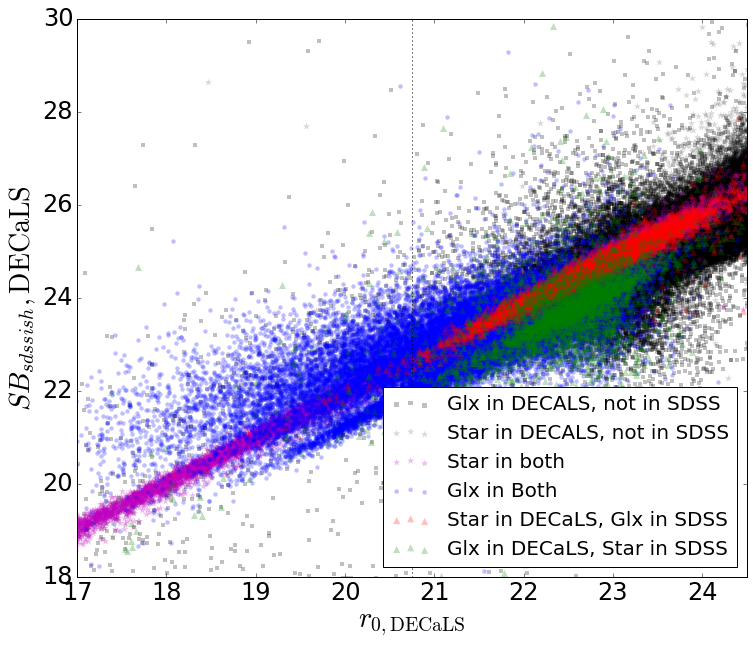

In [106]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sdss_like_sb_r'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['phot_sg']==6


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.25, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.15, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.25, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.25, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.25, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.25, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 30)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{sdssish}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

The below plot is to see if there's significant differences between the two galaxy types, since their SB calculations are quite different

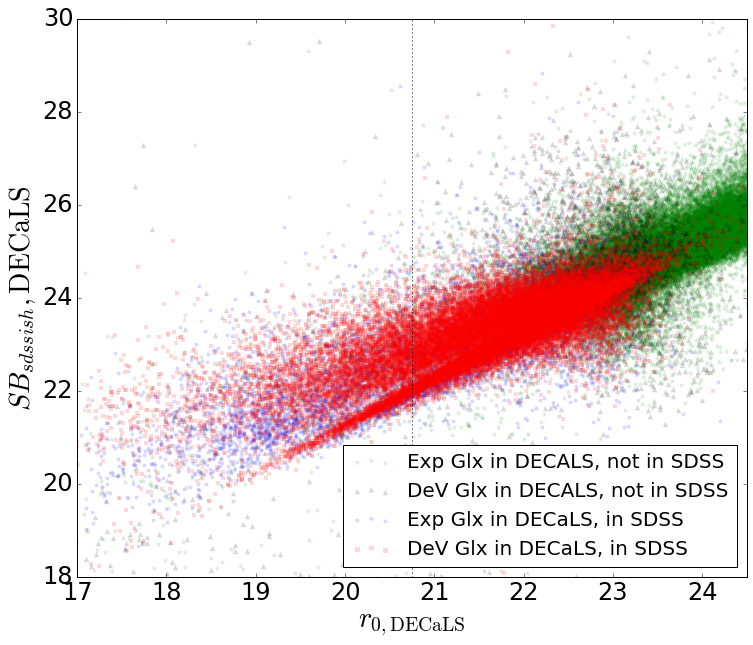

In [103]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sdss_like_sb_r'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
ddev = dmatch['type']=='DEV '
sstar = smatch['phot_sg']==6


dnstar = dnomatch['type']=='PSF '
dndev = dnomatch['type']=='DEV '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])

plt.scatter((dnomatch[xnm] - dnoext)[~dnstar&~dndev], (dnomatch[ynm] - dnoext)[~dnstar&~dndev], 
            c='g', lw=0, alpha=.15, label='Exp Glx in DECALS, not in SDSS', marker='*', s=40)
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar&dndev], (dnomatch[ynm] - dnoext)[~dnstar&dndev], 
            c='k', lw=0, alpha=.15, label='DeV Glx in DECALS, not in SDSS', marker='^', s=30)

plt.scatter(x[~dstar&ddev], y[~dstar&ddev], c='b', lw=0, alpha=.15, 
            label='Exp Glx in DECaLS, in SDSS', marker='o', s=15)
plt.scatter(x[~dstar&~ddev], y[~dstar&~ddev], c='r', lw=0, alpha=.15, 
            label='DeV Glx in DECaLS, in SDSS', marker='s', s=20)




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 30)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{sdssish}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)